# レスラー方程式のサブシステムの予測（外力なし）．

In [246]:
#必要なパッケージのインポート

import numpy as np

import matplotlib
import matplotlib.pyplot as plt

import reservoirpy as rpy

from scipy.integrate import solve_ivp
import pandas as pd
from reservoirpy.observables import nrmse, rsquare


rpy.verbosity(0)

from reservoirpy.nodes import Reservoir, Ridge
from reservoirpy.datasets import mackey_glass

# just a little tweak to center the plots, nothing to worry about
from IPython.core.display import HTML
HTML("""
<style>
.img-center {
    display: block;
    margin-left: auto;
    margin-right: auto;
    }
.output_png {
    display: table-cell;
    text-align: center;
    vertical-align: middle;
    }
</style>
""")

rpy.set_seed(42)

%time

CPU times: user 1e+03 ns, sys: 0 ns, total: 1e+03 ns
Wall time: 1.91 µs


In [247]:
import numpy as np
from scipy.integrate import solve_ivp
import pandas as pd

def rossler(t, state, a, b, c):
    x, y, z = state  
    dxdt = -y - z
    dydt = x + a * y
    dzdt = b + z * (x - c)
    return [dxdt, dydt, dzdt]

a = 0.2
b = 0.2
c = 5.7
initial_state = [1.0, 1.0, 1.0]
t_span = (0, 2510)

sol = solve_ivp(rossler, t_span, initial_state, args=(a, b, c), dense_output=True, t_eval=np.linspace(t_span[0], t_span[1], 25100), max_step = 0.01)

t = sol.t
z = sol.y

# CSVファイルにデータを保存
data = pd.DataFrame({'Time': t, 'x': z[0], 'y': z[1], 'z': z[2]})
data.to_csv('rossler_dataset.csv', index=False)

data_withouttime = pd.DataFrame({'x': z[0], 'y': z[1], 'z': z[2]})

# CSVファイルを読み込む
data_loaded = pd.read_csv('rossler_dataset.csv')

X = data_withouttime.values

X.shape


(25100, 3)

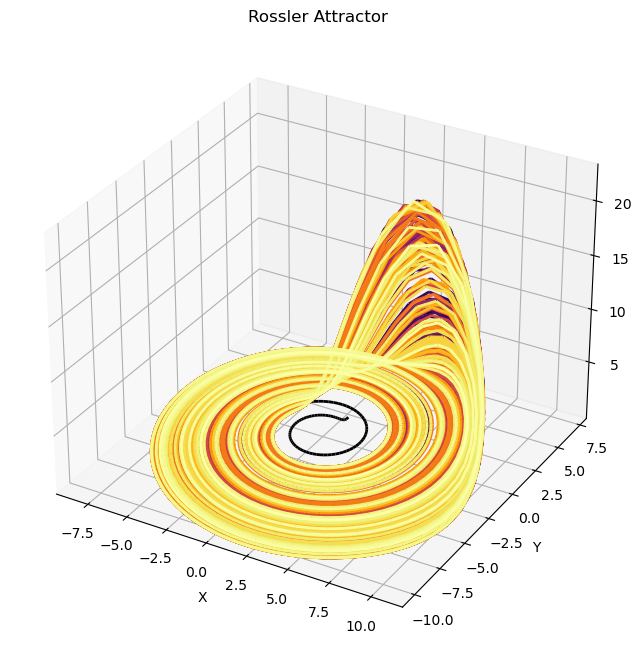

In [248]:
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from mpl_toolkits.mplot3d.art3d import Line3DCollection
import numpy as np

def plot_rossler_3d_colored_efficient(data):
    fig = plt.figure(figsize=(10, 8))
    ax = fig.add_subplot(111, projection='3d')

    # 時間に応じた色の変化を生成
    num_points = len(data)
    points = np.array([data['x'], data['y'], data['z']]).T.reshape(-1, 1, 3)
    segments = np.concatenate([points[:-1], points[1:]], axis=1)
    norm = plt.Normalize(data['Time'].min(), data['Time'].max())
    lc = Line3DCollection(segments, cmap='inferno', norm=norm)
    lc.set_array(data['Time'])
    lc.set_linewidth(2)
    ax.add_collection(lc)

    ax.set_xlim(data['x'].min(), data['x'].max())
    ax.set_ylim(data['y'].min(), data['y'].max())
    ax.set_zlim(data['z'].min(), data['z'].max())
    ax.set_xlabel('X')
    ax.set_ylabel('Y')
    ax.set_zlabel('Z')
    plt.title('Rossler Attractor')
    plt.show()

# ここで `data_loaded` をレスラー方程式の解が含まれたデータフレームと仮定しています。
plot_rossler_3d_colored_efficient(data_loaded)


x項，y項からなるサブシステムを定義する．

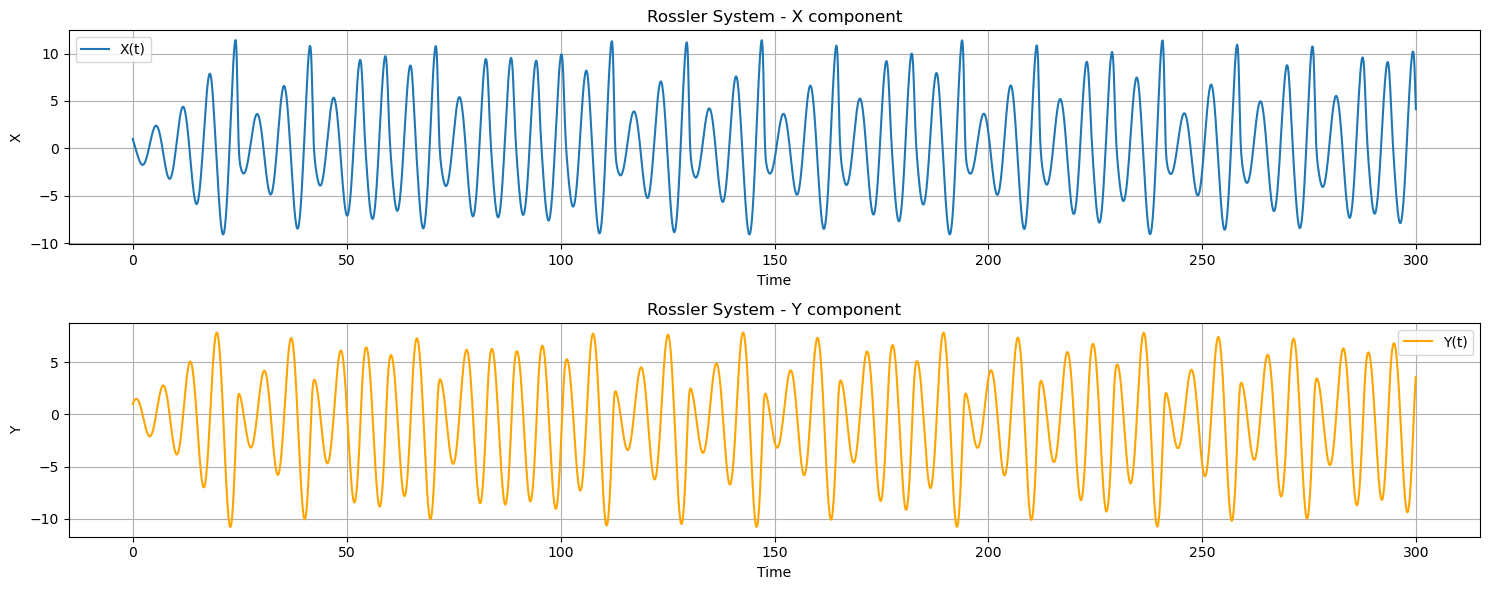

In [249]:
import matplotlib.pyplot as plt

sample = 3000

# サブプロットを作成して、x と y の時系列データを横に並べてプロット
fig, axes = plt.subplots(nrows=2, ncols=1, figsize=(15, 6))  # 1行2列のサブプロット

# X(t)のデータを左側のサブプロットにプロット
axes[0].plot(sol.t[:sample], sol.y[0][:sample], label='X(t)')
axes[0].set_title('Rossler System - X component')
axes[0].set_xlabel('Time')
axes[0].set_ylabel('X')
axes[0].legend()
axes[0].grid(True)

# Y(t)のデータを右側のサブプロットにプロット
axes[1].plot(sol.t[:sample], sol.y[1][:sample], label='Y(t)', color='orange')
axes[1].set_title('Rossler System - Y component')
axes[1].set_xlabel('Time')
axes[1].set_ylabel('Y')
axes[1].legend()
axes[1].grid(True)

# サブプロット間のスペースを調整
plt.tight_layout()

# グラフを表示
plt.show()


In [250]:
X_sub = X[:, :2]

X_sub.shape

(25100, 2)

In [251]:
# Objective functions accepted by ReservoirPy must respect some conventions:
#  - dataset and config arguments are mandatory, like the empty '*' expression.
#  - all parameters that will be used during the search must be placed after the *.
#  - the function must return a dict with at least a 'loss' key containing the result
# of the loss function. You can add any additional metrics or information with other 
# keys in the dict. See hyperopt documentation for more informations.
def objective(dataset, config, *, iss, N, sr, lr, ridge, seed):
    
    # This step may vary depending on what you put inside 'dataset'
    train_data, validation_data = dataset
    X_train, y_train = train_data
    X_val, y_val = validation_data
    
    # You can access anything you put in the config 
    # file from the 'config' parameter.
    instances = config["instances_per_trial"]
    
    # The seed should be changed across the instances, 
    # to be sure there is no bias in the results 
    # due to initialization.
    variable_seed = seed 
    
    losses = []; r2s = [];
    for n in range(instances):
        # Build your model given the input parameters
        reservoir = Reservoir(N, 
                              sr=sr, 
                              lr=lr, 
                              input_scaling=iss, 
                              seed=variable_seed)
        
        readout = Ridge(ridge=ridge)

        model = reservoir >> readout


        # Train your model and test your model.
        predictions = model.fit(X_train, y_train) \
                           .run(X_val)
        
        loss = nrmse(y_val, predictions, norm_value=np.ptp(X_train))
        r2 = rsquare(y_val, predictions)
        
        # Change the seed between instances
        variable_seed += 1
        
        losses.append(loss)
        r2s.append(r2)

    # Return a dictionnary of metrics. The 'loss' key is mandatory when
    # using hyperopt.
    return {'loss': np.mean(losses),
            'r2': np.mean(r2s)}

In [252]:
hyperopt_config = {
    "exp": f"hyperopt-rossler", # the experimentation name
    "hp_max_evals": 200,             # the number of differents sets of parameters hyperopt has to try
    "hp_method": "random",           # the method used by hyperopt to chose those sets (see below)
    "seed": 42,                      # the random state seed, to ensure reproducibility
    "instances_per_trial": 3,        # how many random ESN will be tried with each sets of parameters
    "hp_space": {                    # what are the ranges of parameters explored
        "N": ["choice", 500],             # the number of neurons is fixed to 500
        "sr": ["loguniform", 1e-2, 10],   # the spectral radius is log-uniformly distributed between 1e-2 and 10
        "lr": ["loguniform", 1e-3, 1],  # idem with the leaking rate, from 1e-3 to 1
        "iss": ["uniform", 0, 1],           # the input scaling uniformly distributed between 0 and 1
        "ridge": ["loguniform", 1e-9, 1e-2],        # and so is the regularization parameter.
        "seed": ["choice", 1234]          # an other random seed for the ESN initialization
    }
}


import json

# we precautionously save the configuration in a JSON file
# each file will begin with a number corresponding to the current experimentation run number.
with open(f"{hyperopt_config['exp']}.config.json", "w+") as f:
    json.dump(hyperopt_config, f)

In [253]:
from reservoirpy.datasets import to_forecasting

train_len = 3000
test_len = 4000

x, y = to_forecasting(X_sub, forecast=1)
X_train, y_train = x[:train_len], y[:train_len]
X_test, y_test = x[train_len:train_len+test_len], y[train_len:train_len+test_len]

dataset = ((X_train, y_train), (X_test, y_test))

In [254]:
from reservoirpy.hyper import research

best = research(objective, dataset, "hyperopt-rossler.config.json", "./hyperopt-rossler")

100%|██████████| 200/200 [08:30<00:00,  2.55s/trial, best loss: 1.2550146281022402e-05]


In [245]:
best

({'N': 0,
  'iss': 0.15716834911966804,
  'lr': 0.8156304946175557,
  'ridge': 4.290374941230941e-08,
  'seed': 0,
  'sr': 1.0385323042151453},
 <hyperopt.base.Trials at 0x29f331a00>)

In [237]:
seed_timesteps = 100
nb_generations = 400

In [238]:
def esn_chaos_prediction(X, N, iss, lr, ridge, seed, sr,  seed_timesteps, nb_generations, train_len = 2000, forecast=1,):
    
    n, m = X.shape
    
    from reservoirpy.datasets import to_forecasting

    train_len = train_len

    x, y = to_forecasting(X, forecast=forecast)
    X_train, y_train = x[:train_len], y[:train_len]
    X_test, y_test = x[train_len:], y[train_len:]

    dataset = ((X_train, y_train), (X_test, y_test))
    
    # bestから取得したハイパーパラメータを設定
    N = N
    iss = iss
    lr = lr
    ridge = ridge
    seed = seed
    sr = sr

    # データセットからトレーニングとバリデーションデータを取得
    train_data, validation_data = dataset
    X_train, y_train = train_data
    X_val, y_val = validation_data

    # モデルの構築
    reservoir = Reservoir(N, 
                        sr=sr, 
                        lr=lr, 
                        input_scaling=iss, 
                        seed=seed)
    readout = Ridge(ridge=ridge)
    model = reservoir >> readout
    
    warming_inputs = X_test[:seed_timesteps]

    warming_out = model.fit(X_train, y_train).run(warming_inputs, reset=True)  # warmup
    
    X_gen = np.zeros((nb_generations, m))
    y = warming_out[-1]
    for t in range(nb_generations):  # generation
        y = model(y)
        X_gen[t, :] = y
        
    X_t = X_test[seed_timesteps: nb_generations+seed_timesteps]
    
    return X_gen, X_t, warming_out, warming_inputs

In [239]:
# 描画用のplot_generationの定義

def plot_generation(X_gen, X_t, nb_generations, warming_out=None, warming_inputs=None, seed_timesteps=0):

    plt.figure(figsize=(15, 5))
    if warming_out is not None:
        plt.plot(np.vstack([warming_out, X_gen]), label="Generated timeseries")
    else:
        plt.plot(X_gen, label="Generated timeseries")

    plt.plot(np.arange(nb_generations)+seed_timesteps, X_t, linestyle="--", label="Real timeseries")

    if warming_inputs is not None:
        plt.plot(np.arange(seed_timesteps), warming_inputs, linestyle="--", label="Warmup")

    plt.plot(np.arange(nb_generations)+seed_timesteps, np.abs(X_t - X_gen),
             label="Absolute deviation")

    if seed_timesteps > 0:
        plt.fill_between([0, seed_timesteps], *plt.ylim(), facecolor='lightgray', alpha=0.5, label="Warmup")

    plt.plot([], [], ' ', label=f"$R^2 = {round(rsquare(X_t, X_gen), 4)}$")
    plt.plot([], [], ' ', label=f"$NRMSE = {round(nrmse(X_t, X_gen), 4)}$")
    plt.legend(
    )
    plt.show()

In [240]:
best

({'N': 0,
  'iss': 0.15716834911966804,
  'lr': 0.8156304946175557,
  'ridge': 4.290374941230941e-08,
  'seed': 0,
  'sr': 1.0385323042151453},
 <hyperopt.base.Trials at 0x29f331a00>)

In [241]:
X_gen, X_t, warming_out, warming_inputs = esn_chaos_prediction(X_sub, 500, 0.15716834911966804, 0.8156304946175557, 4.290374941230941e-08, 1234, 1.0385323042151453, seed_timesteps, nb_generations)

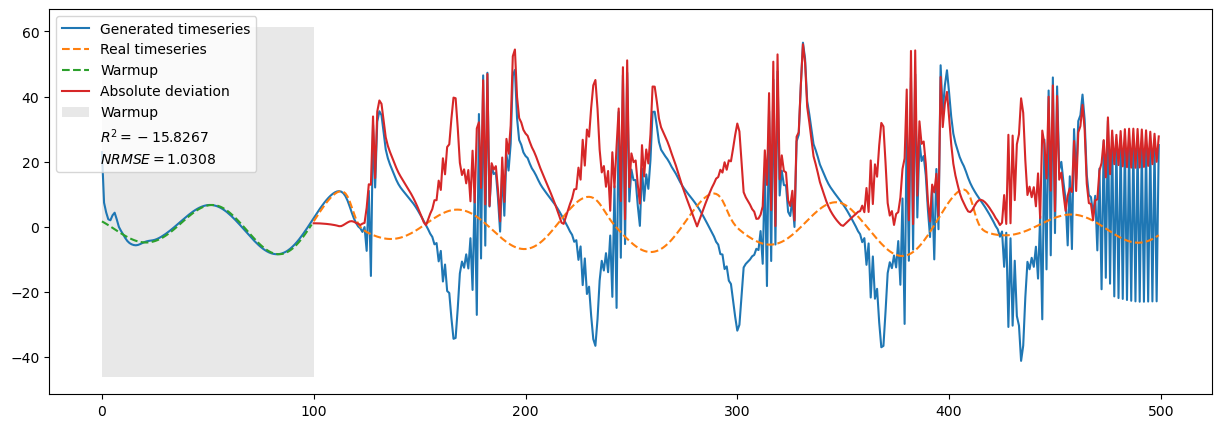

In [242]:
plot_generation(X_gen[:, :1], X_t[:, :1], nb_generations, warming_out=warming_out[:, :1],
                warming_inputs=warming_inputs[:, :1], seed_timesteps=seed_timesteps)

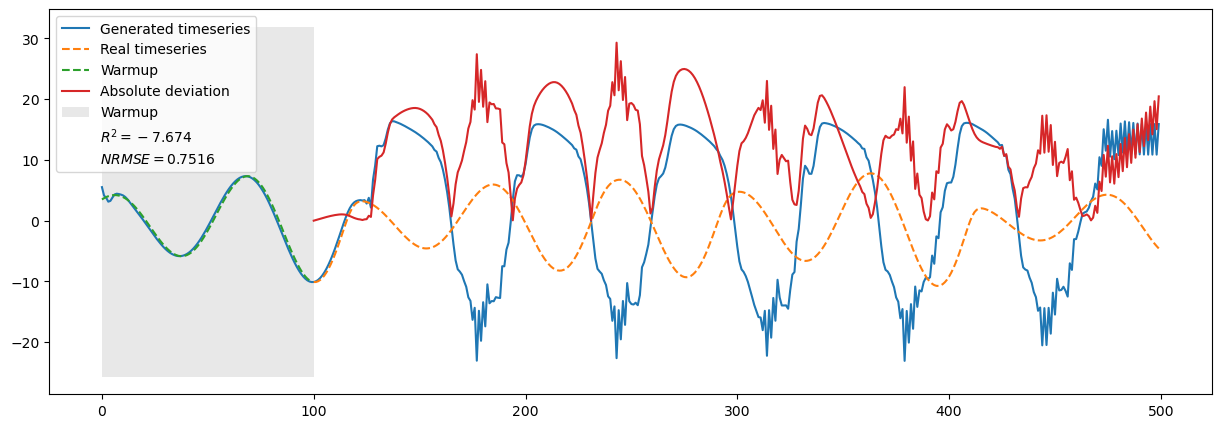

In [243]:
plot_generation(X_gen[:, 1:2], X_t[:, 1:2], nb_generations, warming_out=warming_out[:, 1:2],
                warming_inputs=warming_inputs[:, 1:2], seed_timesteps=seed_timesteps)

### ここまで，外力なしでのサブシステムの予測を見た．

だんだん予測が外れていく様が見て取れるが，100ステップ（1000刻み幅）先までは予測できていそうだ．

次のステップとして考えられること：
1. 外力のある場合を考える→今までの経験を踏まえると，外力の実データを常に与え続ければ予測誤差は常に爆発しない．
2. 入力であるXに異なる振幅のガウシアンノイズを挿入する．→先行研究を踏まえれば，ある振幅では確率共鳴が起こる．
3. 1と2の組み合わせ：ノイズが大きく予測が難しい場合に関して，外力の実データを常に与え続けることで，レスラー方程式のサブシステムのX, Y項の真の値の予測を行う．

#注意

最適化とesnの実行

In [244]:
X

array([[ 1.        ,  1.        ,  1.        ],
       [ 0.81385718,  1.11163049,  0.63493375],
       [ 0.64680298,  1.20777255,  0.40196368],
       ...,
       [-7.69976375,  3.78643257,  0.01532156],
       [-8.04437468,  3.06721505,  0.01485158],
       [-8.31468333,  2.30236019,  0.01449152]])